# PyTorch Neural Network -- fashion MNIST

    Thomas Moreau <thomas.moreau@inria.fr>
    Alexandre Gramfort <alexandre.gramfort@inria.fr>
    
Notebook inspired from materials from [PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html).

Start by importing helpers from `torch` and `torchvision`:

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Compose, Normalize
from torchvision.transforms import RandomHorizontalFlip, RandomCrop

### Load data - Fashion MNIST

Fashion MNIST is a dataset with images of clothes from 10 categories:

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",     # Where to store the data
    train=True,      # Which part of the dataset to load (train set)
    download=True,   # Download the data if necessary
    # Transform for data augmetation.
    transform=Compose([
        RandomHorizontalFlip(),
        RandomCrop(size=28, padding=4),
        ToTensor(),
        Normalize([0.2700], [0.3500]),
    ]),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False, 
    download=True,
    transform=Compose([ToTensor(), Normalize((0.2700,), (0.3500,))])
)

print("Classes:", training_data.classes)

print(f"Training samples: {len(training_data) / 1000:.0f}k\n"
      f"Test samples: {len(test_data) / 1000:.0f}k")

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Training samples: 60k
Test samples: 10k


In [3]:
print(f"Type: {type(training_data[0])}\n")
X, y = training_data[0]
print(f"X shape: {X.shape}\ny: {y}")

Type: <class 'tuple'>

X shape: torch.Size([1, 28, 28])
y: 9


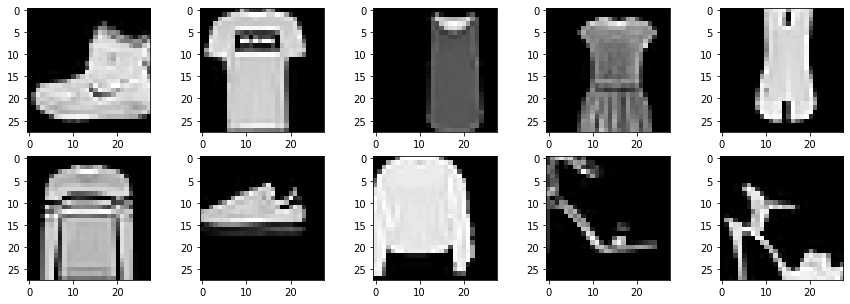

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(training_data[i][0][0], cmap='gray')

### Accessing batch of images -- DataLoader

To train the network, we want to use SGD with minibatch of data.
A convenient way to iterate through the samples is to use a `DataLoader`:

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

X, y = next(iter(test_dataloader))
print(f"Shape of X [N, C, H, W]: {X.shape}")
print(f"Shape of y: {y.shape} {y.dtype}")

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Creating a Network -- nn.Module

Now, we will define a simple feedforward fully connected model:

In [6]:
# Define model
class NeuralNetwork(nn.Module):

    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Using the right computation architecture - CPU vs GPU

In [7]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = model.to(device)

Using cpu device


### Defining the training procedure -- Loss and Optimizer

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [10]:
def eval_model(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [11]:
epochs = 5

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
for t in range(epochs):
    print(f"Epoch {t+1}\n{'-' * 20}")
    train_epoch(train_dataloader, model, loss_fn, optimizer)
    eval_model(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
--------------------
loss: 2.296746  [    0/60000]
loss: 2.263142  [ 6400/60000]
loss: 2.237259  [12800/60000]
loss: 2.235446  [19200/60000]
loss: 2.177714  [25600/60000]
loss: 2.151674  [32000/60000]
loss: 2.106089  [38400/60000]
loss: 2.090389  [44800/60000]
loss: 2.036337  [51200/60000]
loss: 1.989083  [57600/60000]
Test Error: 
 Accuracy: 45.2%, Avg loss: 1.891140 

Epoch 2
--------------------
loss: 1.975793  [    0/60000]
loss: 1.987635  [ 6400/60000]
loss: 1.846051  [12800/60000]
loss: 1.876652  [19200/60000]
loss: 1.767900  [25600/60000]
loss: 1.756965  [32000/60000]
loss: 1.652499  [38400/60000]
loss: 1.726842  [44800/60000]
loss: 1.700021  [51200/60000]
loss: 1.671557  [57600/60000]
Test Error: 
 Accuracy: 53.1%, Avg loss: 1.417879 

Epoch 3
--------------------
loss: 1.581877  [    0/60000]
loss: 1.608697  [ 6400/60000]
loss: 1.400350  [12800/60000]
loss: 1.545740  [19200/60000]
loss: 1.488788  [25600/60000]
loss: 1.525581  [32000/60000]
loss: 1.468803  [38400/60000]

### Computational bottleneck for NN training

We now explore the computational bottleneck for training the network with `snakeviz`.

In [13]:
%load_ext snakeviz

In [14]:
%%snakeviz

epochs = 2
num_workers = 1  # set it to 8 to see what it changes

train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_epoch(train_dataloader, model, loss_fn, optimizer)
    eval_model(test_dataloader, model, loss_fn)
print("Done!")

# Run on terminal to visualise
# snakeviz /var/folders/7t/pqn1g_1j729gzxpp_k1qhd2h0000gn/T/tmp2aeoqveq

Epoch 1
-------------------------------
loss: 1.261948  [    0/60000]
loss: 1.232226  [ 6400/60000]
loss: 1.027392  [12800/60000]
loss: 1.267196  [19200/60000]
loss: 1.252985  [25600/60000]
loss: 1.249158  [32000/60000]
loss: 1.149755  [38400/60000]
loss: 1.190495  [44800/60000]
loss: 1.379774  [51200/60000]
loss: 1.167565  [57600/60000]
Test Error: 
 Accuracy: 64.3%, Avg loss: 1.015493 

Epoch 2
-------------------------------
loss: 1.244510  [    0/60000]
loss: 1.214655  [ 6400/60000]
loss: 1.012857  [12800/60000]
loss: 1.203403  [19200/60000]
loss: 1.146710  [25600/60000]
loss: 1.193430  [32000/60000]
loss: 1.128819  [38400/60000]
loss: 1.102476  [44800/60000]
loss: 1.216871  [51200/60000]
loss: 1.115336  [57600/60000]
Test Error: 
 Accuracy: 66.0%, Avg loss: 0.963412 

Done!
 
*** Profile stats marshalled to file '/var/folders/7t/pqn1g_1j729gzxpp_k1qhd2h0000gn/T/tmp2aeoqveq'.
Embedding SnakeViz in this document...
